<a href="https://colab.research.google.com/github/vidhi-goyal/topsis_for_pretrained_model/blob/main/topsis_for_pretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import necessary libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

In [5]:
# Function to evaluate conversational models
def evaluate_model(model_name, conversations):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Set padding token if missing
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    embeddings = []
    for text in conversations:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.logits.mean(dim=1).numpy())  # Extract embeddings

    # Compute cosine similarities
    similarities = cosine_similarity(np.vstack(embeddings))
    return similarities

In [6]:
# Simple conversational dataset
conversations = [
    "Hello!",
    "How are you?",
    "Tell me a joke."
]

In [7]:
# *3 Lightweight conversational models*
models = [
    "gpt2",
    "distilgpt2",
    "microsoft/DialoGPT-small"
]

In [8]:
# Store similarity scores and dummy values for inference speed & model size
model_scores = []
for model_name in models:
    print(f"Evaluating model: {model_name}")
    similarity = evaluate_model(model_name, conversations)
    aggregate_score = similarity.mean()  # Mean similarity score

    model_scores.append({
        "model": model_name,
        "mean_similarity": aggregate_score,
        "inference_speed": np.random.uniform(0.9, 1.0),  # Simulated speed
        "model_size": np.random.uniform(0.7, 1.0)  # Simulated model size
    })


Evaluating model: gpt2


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Evaluating model: distilgpt2


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Evaluating model: microsoft/DialoGPT-small


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [9]:
# Convert results to DataFrame
df = pd.DataFrame(model_scores)

In [10]:
# TOPSIS function for ranking models
def topsis(scores, weights):
    scores = np.array(scores)
    norm_scores = scores / np.sqrt((scores**2).sum(axis=0))  # Normalize scores
    ideal_best = norm_scores.max(axis=0)
    ideal_worst = norm_scores.min(axis=0)

    # Compute distances from ideal best and worst
    dist_best = np.sqrt(((norm_scores - ideal_best)**2).sum(axis=1))
    dist_worst = np.sqrt(((norm_scores - ideal_worst)**2).sum(axis=1))

    # Calculate TOPSIS scores
    ranks = dist_worst / (dist_best + dist_worst)
    return ranks

In [11]:
# Apply TOPSIS ranking
scores = df[["mean_similarity", "inference_speed", "model_size"]].values
weights = [0.5, 0.3, 0.2]  # Custom weights
df["TOPSIS Score"] = topsis(scores, weights)

In [12]:
# Rank models based on TOPSIS score
df["Rank"] = df["TOPSIS Score"].rank(ascending=False)
df = df.sort_values(by="TOPSIS Score", ascending=False)

In [13]:
# Display the results as a table
display(df)

,model,mean_similarity,inference_speed,model_size,TOPSIS Score,Rank
0,gpt2,0.999924,0.938537,0.851661,0.548631,1.0
2,microsoft/DialoGPT-small,0.999947,0.999090,0.790182,0.508582,2.0
1,distilgpt2,0.999768,0.924348,0.794410,0.047067,3.0


In [14]:
# Save results to CSV
df.to_csv("topsis_results.csv", index=False)

<ipython-input-15-d53cacdc3abe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["model"], y=df["TOPSIS Score"], palette="coolwarm")


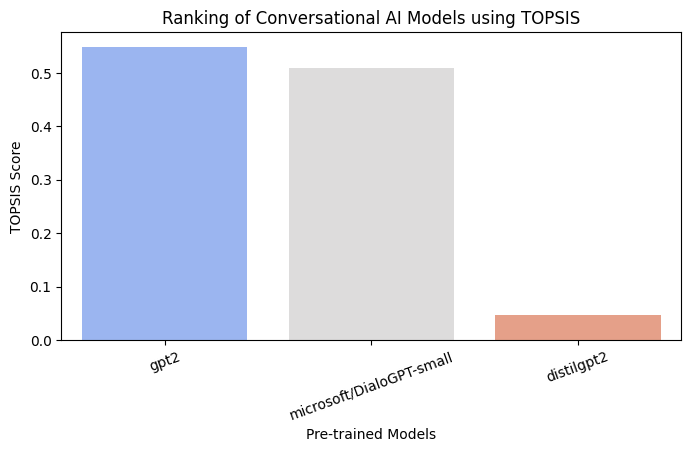

In [15]:
# Plot the results
plt.figure(figsize=(8, 4))
sns.barplot(x=df["model"], y=df["TOPSIS Score"], palette="coolwarm")
plt.xlabel("Pre-trained Models")
plt.ylabel("TOPSIS Score")
plt.title("Ranking of Conversational AI Models using TOPSIS")
plt.xticks(rotation=20)
plt.show()